<center>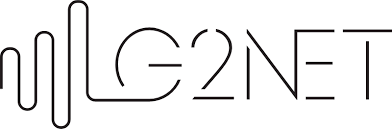</center>

## <center>G2Net Gravitational Wave Detection</center>
### <center>🔭Find gravitational wave signals from binary black hole collisions📡</center>

# Table of Contents  <a id='0.1'></a>

1. [Introduction](#1)
2. [Import Packages](#2)
3. [Utility](#3)
4. [Data Overview](#4)
   * [Trainig Labels](#4.1)
   * [Train Folder](#4.2)
   * [Time Series Dataframe](#4.3)
4. [Visualization](#5)
   * [Target Variables](#5.1)
   * [Time Series (Target=1)](#5.2)
   * [Time Series (Target=0)](#5.3)
   * [Spectrograms](#5.4)
   * [Q-Transform](#5.5)
   * [Constant Q-Transform](#5.6)
6. [Reference](#6)
7. [Glossary](#0)

# 1. <a id="1">Introduction</a>
[Table of contents](#0.1)

This competition is hosted by [European Gravitational Observatory (EGO)](https://www.ego-gw.it/). The **goal** in this competition is to detect **Gravitational Wave** signals from the collisions of binary black holes. We are suppose to build a model which can analyze simulated gravitational wave time-series data from a network of Earth-based detectors.

We are provided with huge **72 GB time-series** dataset containing simulated gravitational wave measurements from a network of 3 gravitational wave [interferometers](#0.2) (LIGO Hanford, LIGO Livingston, and Virgo). Each time series contains either detector noise or detector noise plus a simulated gravitational wave signal. The task is to identify when a signal is present in the data or not.

# 2. <a id="2">Import Packages</a>
[Table of contents](#0.1)

In [ ]:
!python -m pip install gwpy
!pip install -q nnAudio

In [ ]:
# basic utility
import os, gc
import glob
import warnings
import numpy as np
import pandas as pd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec

# gw visualization
from gwpy.plot import Plot
from gwpy.timeseries import TimeSeries
from nnAudio.Spectrogram import CQT

# deep learning/modelling
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

%matplotlib inline
warnings.filterwarnings('ignore')

Let's have quick look at directory structure and files we are going to deal with. 

In [ ]:
# directory
print('Competition Data/Files')
ROOT = '../input/g2net-gravitational-wave-detection/'
os.listdir(ROOT)

# 3. <a id="3">Utility</a>
[Table of contents](#0.1)

In [ ]:
# get filepath
def get_ts_file(file_id):
    return f"../input/g2net-gravitational-wave-detection/train/{file_id[0]}/{file_id[1]}/{file_id[2]}/{file_id}.npy"

# load .npy files
def generate_ts(file_id):
    return np.load(f"../input/g2net-gravitational-wave-detection/train/{file_id[0]}/{file_id[1]}/{file_id[2]}/{file_id}.npy")

# apply q transform
def apply_qtransform(waves, transform):
    waves = np.hstack(waves)
    waves = waves / np.max(waves)
    waves = torch.from_numpy(waves).float()
    image = transform(waves)
    return image

# generate dataframe
def generate_ts_df(id):
    data = pd.DataFrame(np.asmatrix(generate_ts(id))).T
    data.index.name = "Time"
    data.reset_index(inplace=True)
    data.rename(columns={0:"LIGO Hanford", 1: "LIGO Livingston", 2: "Virgo"}, inplace=True)
    return data

# plot timeseries
def plotTimeseries(id, target): 
    
    data = generate_ts_df(id)

    f = plt.figure(figsize=(16, 8))
    gs = f.add_gridspec(3, 1)

    f.suptitle(f"For Observation {id} and Target = {target}", fontsize=20)
    
    with sns.axes_style("whitegrid"):
        sub_spec = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0], width_ratios = (.80, .20), wspace=0.1, hspace=0.1)

        ax1 = plt.Subplot(f, sub_spec[0])
        ax2 = plt.Subplot(f, sub_spec[1])

        sns.lineplot(data['Time'], data['LIGO Hanford'], color='red', ax=ax1)
        sns.kdeplot(y = data['LIGO Hanford'], color='red', shade=True, ax=ax2)

        f.add_subplot(ax1)
        f.add_subplot(ax2)

        ax1.axes.get_xaxis().set_visible(False)
        ax1.set(title="Time Series (LIGO Hanford)", ylabel = "")

        ax2.set_yticks([])
        ax2.set(ylabel='', title="Time Series (LIGO Hanford)")
        ax2.axes.get_xaxis().set_visible(False)

    with sns.axes_style("whitegrid"):
        sub_spec = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[1], width_ratios = (.80, .20), wspace=0.1, hspace=0.1)

        ax1 = plt.Subplot(f, sub_spec[0])
        ax2 = plt.Subplot(f, sub_spec[1])

        sns.lineplot(data['Time'], data['LIGO Livingston'], color='blue', ax=ax1)
        sns.kdeplot(y = data['LIGO Livingston'], color='blue', shade=True, ax=ax2)

        f.add_subplot(ax1)
        f.add_subplot(ax2)

        ax1.axes.get_xaxis().set_visible(False)
        ax1.set(title="Time Series (LIGO Livingston)", ylabel="Strain Noise(10^-20)")

        ax2.set_yticks([])
        ax2.axes.get_xaxis().set_visible(False)
        ax2.set(ylabel='', title="Time Series (LIGO Livingston)")

    with sns.axes_style("whitegrid"):
        sub_spec = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[2], width_ratios = (.80, .20), wspace=0.1, hspace=0.1)

        ax1 = plt.Subplot(f, sub_spec[0])
        ax2 = plt.Subplot(f, sub_spec[1])

        sns.lineplot(data['Time'], data['Virgo'], color='green', ax=ax1)
        sns.kdeplot(y = data['Virgo'], color='green', shade=True, ax=ax2)

        f.add_subplot(ax1)
        f.add_subplot(ax2)

        ax1.set(title="Time Series (Virgo)", ylabel='')

        ax2.set_yticks([])
        ax2.set(ylabel='', title="Time Series (Virgo)")

# plot spectrogram
def plotSpectrogram(id, target): 
    
    data = generate_ts_df(id)

    f = plt.figure(figsize=(16, 8))
    gs = f.add_gridspec(1, 3)

    f.suptitle(f"Spectrogram For Observation {id} and Target = {target}", fontsize=14)
    
    with sns.axes_style("whitegrid"):
        f.add_subplot(gs[0, 0])
        plt.specgram(data['LIGO Hanford'], Fs=2048)
        plt.title("Spectrogram (LIGO Hanford)")
        plt.ylabel("Frequency (Hz)")
        plt.xlabel("")
        plt.xticks(range(0, 3))

    with sns.axes_style("whitegrid"):
        f.add_subplot(gs[0, 1])
        plt.specgram(data['LIGO Livingston'], Fs=2048)
        plt.title("Spectrogram (LIGO Livingston)")
        plt.xlabel("Time(seconds)")
        plt.ylabel("")
        plt.xticks(range(0, 3))

    with sns.axes_style("whitegrid"):
        f.add_subplot(gs[0, 2])
        plt.specgram(data['Virgo'], Fs=2048)
        plt.title("Spectrogram (Virgo)")
        plt.xlabel("")
        plt.ylabel("")
        plt.xticks(range(0, 3))
        
# plot CQT
def plotCQT(id, target, transform):
    
    image = apply_qtransform(generate_ts(id), transform)
    
    f = plt.figure(figsize=(16, 8))
    plt.title(f"Constant Q-Transform For Observation {id} and Target = {target}", fontsize=14)  
    plt.imshow(image[0])

# 4. <a id="4">Data Overview</a>
[Table of contents](#0.1)

We are provided with **train** and **test** folders. For every observation in **train.csv** we have one **.npy** file. Labels are provided in a **training_labels.csv** file. Each data sample (npy file) contains 3 time series (1 for each detector) and each spans 2 sec and is sampled at 2,048 Hz.

## 4.1 <a id="4.1">Training Labels</a>

In [ ]:
train = pd.read_csv(os.path.join(ROOT, 'training_labels.csv'))
train.head()

In [ ]:
print(f"We have total {train.shape[0]} rows and {train.shape[1]} columns in train.csv.")

### Missing Values

In [ ]:
print(f'Missing values in training_label.csv in each columns:\n{train.isnull().sum()}')

### Unique Values

In [ ]:
print('Unique Values in each column of training_labels.csv')
print('##########################################')
for col in train:
    print(f'{col}: {train[col].nunique()}')

**📌 Points to note**
   * We have two columns in training label file i.e "id" and "target".
   * There are total **5,60,000** observations and 2 columns in training label file.
   * Also there are no missing values.
   * We can see that all **id** are unique.

## 4.2 <a id="4.2">Train Folder</a>
[Table of contents](#0.1)

We are given train and test folders. As you can see in **Data** pane each **.npy file** is organised in nested structure inside this folders at 3 subsequent levels. Each file consists of three time series one from each detector (LIGO Hanford, LIGO Livingston, and Virgo) and each spands 2 second. Let us chck the shape of each **.npy** file.

In [ ]:
for i in train.id[:10]:
    print(f"The shape of file {i}: {generate_ts(i).shape}")

**📌 Points to note**
   * We can expect that shape of every **.npy** is going to be (3, 4096). The 3 represent three time series from respective detectors (LIGO Hanford, LIGO Livingston, and Virgo).

## 4.3 <a id="4.3">Time Series DataFrame</a>
[Table of contents](#0.1)

Let's see how the .npy files look like. I have converted the numpy arrays in dataframe for more efficient working. 

In [ ]:
generate_ts_df(train.id[0]).head()

**📌 Points to note**
   * Here we can see that signal from each of the three detectors. 
   * Each column contain time-series data from 3 different detectors (LIGO Hanford, LIGO Livingston and Virgo).

# 5. <a id="5">Data Visualization</a>
[Table of contents](#0.1)

## 5.1 <a id="5.1">Target Variables</a>

In [ ]:
plt.figure(figsize=(16,10))

with sns.axes_style("whitegrid"):
    ax = sns.countplot(train['target'], palette='Pastel1')
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/len(train)*100),
                ha="center", fontsize=12)
    plt.title("Target Distribution", fontsize=16)

**📌 Points to note**
   * We can see that **target** variable is evenly distributed. Both 1 and 0 are 50%. 

## 5.2 <a id="5.2">Time Series (Target=1)</a>
[Table of contents](#0.1)

In [ ]:
plotTimeseries(train.id[0], train.target[0])

## 5.3 <a id="5.3">Time Series (Target=0)</a>
[Table of contents](#0.1)

In [ ]:
plotTimeseries(train.id[1], train.target[1])

## 5.4 <a id="5.4">Spectrograms</a>
[Table of contents](#0.1)

A [spectrogram](#0.3) is a visual representation of the spectrum of frequencies of a signal as it varies with time. 

In [ ]:
plotSpectrogram(train.id[1], train.target[1])

In [ ]:
plotSpectrogram(train.id[0], train.target[0])

## 5.5 <a id="5.5">Q-Transform</a>
[Table of contents](#0.1)

One of the most useful tools for filtering and visualising short-duration features in a TimeSeries is the [Q-transform](#0.3).

### Target = 1

In [ ]:
d1 = TimeSeries(generate_ts_df(train.id[0])['LIGO Hanford'], sample_rate=2048).q_transform(outseg=(0, 2)).plot()
d1 = d1.gca()
d1.set_xscale('seconds')
d1.set_yscale('log')
d1.set_title('Q-Transform (LIGO Hanford)')
d1.set_xlabel('Time (s)')
d1.set_ylabel('Frequency (Hz)')
d1.grid(False)
d1.colorbar(cmap='viridis', label='Normalized energy')

d2 = TimeSeries(generate_ts_df(train.id[0])['LIGO Livingston'], sample_rate=2048).q_transform(outseg=(0, 2)).plot()
d2 = d2.gca()
d2.set_xscale('seconds')
d2.set_yscale('log')
d2.set_title('Q-Transform (LIGO Livingston)')
d2.set_xlabel('Time (s)')
d2.set_ylabel('Frequency (Hz)')
d2.grid(False)
d2.colorbar(cmap='viridis', label='Normalized energy')

d3 = TimeSeries(generate_ts_df(train.id[0])['Virgo'], sample_rate=2048).q_transform(outseg=(0, 2)).plot()
d3 = d3.gca()
d3.colorbar(cmap='viridis', label='Normalized energy')
d3.set_xscale('seconds')
d3.set_yscale('log')
d3.set_title('Q-Transform (Virgo)')
d3.set_xlabel('Time (s)')
d3.set_ylabel('Frequency (Hz)')
d3.grid(False)

### Target = 0

In [ ]:
d1 = TimeSeries(generate_ts_df(train.id[1])['LIGO Hanford'], sample_rate=2048).q_transform(outseg=(0, 2)).plot()
d1 = d1.gca()
d1.set_xscale('seconds')
d1.set_yscale('log')
d1.set_title('Q-Transform (LIGO Hanford)')
d1.set_xlabel('Time (s)')
d1.set_ylabel('Frequency (Hz)')
d1.grid(False)
d1.colorbar(cmap='viridis', label='Normalized energy')

d2 = TimeSeries(generate_ts_df(train.id[1])['LIGO Livingston'], sample_rate=2048).q_transform(outseg=(0, 2)).plot()
d2 = d2.gca()
d2.set_xscale('seconds')
d2.set_yscale('log')
d2.set_title('Q-Transform (LIGO Livingston)')
d2.set_xlabel('Time (s)')
d2.set_ylabel('Frequency (Hz)')
d2.grid(False)
d2.colorbar(cmap='viridis', label='Normalized energy')

d3 = TimeSeries(generate_ts_df(train.id[1])['Virgo'], sample_rate=2048).q_transform(outseg=(0, 2)).plot()
d3 = d3.gca()
d3.colorbar(cmap='viridis', label='Normalized energy')
d3.set_xscale('seconds')
d3.set_yscale('log')
d3.set_title('Q-Transform (Virgo)')
d3.set_xlabel('Time (s)')
d3.set_ylabel('Frequency (Hz)')
d3.grid(False)

## 5.6 <a id="5.6">Constant Q-Transform</a>
[Table of contents](#0.1)

In [ ]:
transform = CQT(sr=2048, fmin=20, fmax=1024, hop_length=64)  

In [ ]:
plotCQT(train.id[0], train.target[0], transform)

In [ ]:
plotCQT(train.id[1], train.target[1], transform)

# 6 <a id="6">References</a>
[Table of contents](#0.1)

   * [Constant Q-Tramsform Demonstartion](https://www.kaggle.com/atamazian/nnaudio-constant-q-transform-demonstration).
   * https://www.kaggle.com/yasufuminakama/g2net-efficientnet-b7-baseline-training/notebook

# Glossary <a id='0'></a>
[Table of contents](#0.1)

* <a id='0.2'>Interferometers</a> -  are investigative tools used in many fields of science and engineering. They are called interferometers because they work by merging two or more sources of light to create an interference pattern, which can be measured and analyzed; hence 'Interfere-o-meter', or interferometer. They are used to measure everything from the smallest variations on the surface of a microscopic organism, to the structure of enormous expanses of gas and dust in the distant Universe, and now, to detect gravitational waves. [source](https://www.ligo.caltech.edu/page/what-is-interferometer)

* <a id='0.3'>Spectrograms</a> - A spectrogram is a visual way of representing the signal strength, or “loudness”, of a signal over time at various frequencies present in a particular waveform. Not only can one see whether there is more or less energy at, for example, 2 Hz vs 10 Hz, but one can also see how energy levels vary over time. [source](https://pnsn.org/spectrograms/what-is-a-spectrogram)

# IN PROGRESS...